# 导入库

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm as tqdm 
import torch
import os
from pathlib import Path
import struct
import torch.nn as nn
import gzip
import array
import math
import torch
from torch.optim import Optimizer
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader ,TensorDataset
from sklearn.model_selection import train_test_split as Split
from tensorboard import notebook

# Parameter

In [5]:
config={
    "seed":1314,
    "data_dir":"./data",
    "train_image":"train-images-idx3-ubyte.gz",
    "train_label":"train-labels-idx1-ubyte.gz",
    "test_image":"t10k-images-idx3-ubyte.gz",
    "test_label":"t10k-labels-idx1-ubyte.gz",
    "n_epoch":300,
    "warmup_steps": 1000,
    "early_stop": 1000,
    "save_path": "./models/model.ckpt",  # save.
    "batch_size":150
}
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Decode idx3 and idx1

In [6]:
print(Path(config["data_dir"]).absolute())
test_image_dir=os.path.join(Path(config["data_dir"]) ,config["test_image"])
train_image_dir=os.path.join(Path(config["data_dir"]) , config["train_image"])
test_label_dir=os.path.join(Path(config["data_dir"]) , config["test_label"])
train_label_dir=os.path.join(Path(config["data_dir"]) , config["train_label"])
print(test_image_dir)

def decode_idx3_image(idx3file):
    with gzip.open(idx3file,'rb') as f:
        fmt_header='>iiii'  #定义读取的格式字符串大端序 一次读取4个整数(四个字节) 4*8=32bit /进行地址偏移
        offset=f.read(16)   #第一次读取16个字节/首地址或者说是绝对地址的开头 详情见  (https://blog.csdn.net/weixin_38118997/article/details/103670901)
        magic_number,num_image,num_rows,num_cols=struct.unpack(fmt_header,offset)
        image_size=num_cols*num_rows
        images = np.empty((num_image, 1,num_rows, num_cols))
        # images=np.frombuffer(f.read(), dtype=np.uint8).reshape(num_image, 28,28)    
        #读取数据并且转换为整数 使用下列方法需要复杂的数据转换极度麻烦
        for i in range(num_image):
            # print(f.read(image_size))
            obj=array.array('b')
            obj.frombytes(f.read(image_size))
            image_data=np.array(obj)
            # print(image_data)
            image_data=image_data.reshape(1,num_rows,num_cols)
            images[i]=image_data
    return images


def decode_idx1_label(idx1file):
    with gzip.open(idx1file,'rb') as f:
        fmt_header = '>ii'
        offset=f.read(8)
        magic_number,num_label=struct.unpack(fmt_header,offset)
        labels=np.frombuffer(f.read(),dtype=np.uint8)
    return labels    

c:\Users\方伟杰\Desktop\DL\CNNM\data
data\t10k-images-idx3-ubyte.gz


# Loader

In [9]:
test_image=decode_idx3_image(test_image_dir)
train_image=decode_idx3_image(train_image_dir)
test_label=decode_idx1_label(test_label_dir)  #压缩维度为(num)
train_label=decode_idx1_label(train_label_dir)

# Show

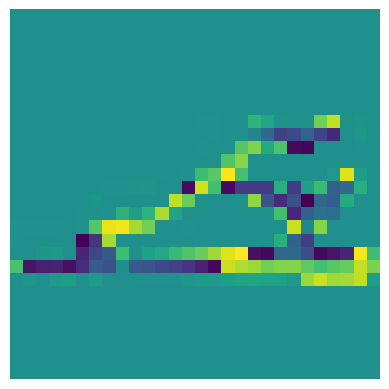

In [27]:
plt.imshow(train_image[300][0],vmin=-128, vmax=127) 
plt.axis('off')
plt.show()

# Model

In [13]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier,self).__init__()
        self.cnn_layer=nn.Sequential(
            nn.Conv2d(1,16,3,1,1),
            nn.BatchNorm2d(16,1e5),
            nn.ReLU(),

            nn.Conv2d(16,32,3,1,1),
            nn.BatchNorm2d(32,1e5),
            nn.ReLU(),
            nn.MaxPool2d((2,2),(2,2),padding=0),

            nn.Conv2d(32, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d((2,2),(2,2),padding=0),
        )
        self.fc_layer=nn.Sequential(
            nn.Linear(64*7*7,64),
            nn.ReLU(),
            nn.Linear(64,32),
            nn.ReLU(),
            nn.Linear(32,10)
        )
        
    def forward(self,x):
        
        x=self.cnn_layer(x)

        x = x.flatten(1)
        
        x=self.fc_layer(x)

        return x

# 学习率

In [29]:
def get_cosine_schedule_with_warmup(
    optimizer: Optimizer,
    num_warmup_steps: int,
    num_training_steps: int,
    num_cycles: float = 0.5,
    last_epoch: int = -1,
):
    def lr_lambda(current_step):
        if current_step<num_warmup_steps:
            return float(current_step)/float(num_warmup_steps)
        else:
            progress = float(current_step - num_warmup_steps) / float(
            max(1, num_training_steps - num_warmup_steps))
            return max(0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress)))
    return LambdaLR(optimizer, lr_lambda, last_epoch)
            
        

# Batch

In [7]:
def batch_collate(data,label,batch_size=150):
    label=label.astype(np.int64)
    Image=torch.tensor(data)
    label=torch.tensor(label)
    one_hot_labels = torch.nn.functional.one_hot(label, 10)
    Image=Image.to(torch.float)
    label=one_hot_labels.to(torch.float)
    data_row = TensorDataset(Image,label)
    # print(label.shape)
    # print(Image.shape)
    dataload = DataLoader(data_row, batch_size=batch_size, shuffle=True)
    return dataload


# Train

In [31]:
def Train(train_loader, valid_loader, model, config, device):
    criterion=nn.CrossEntropyLoss()
    optimizer=torch.optim.AdamW(model.parameters(), lr=1e-4)
    writer = SummaryWriter()
    if not os.path.isdir('./models'):
        os.mkdir('./models') # Create directory of saving models.
    n_epoch, best_loss, step, early_stop_count = config["n_epoch"], math.inf, 0, 0
    scheduler = get_cosine_schedule_with_warmup(optimizer, config["warmup_steps"], n_epoch*config["batch_size"])
    for epoch in range(n_epoch):
        model.train()
        for x ,y in train_loader:
            optimizer.zero_grad()
            # print(x.shape)
            x,y=x.to(device),y.to(device)
            L=model(x)
            batch_loss = criterion(L, y)
            batch_loss.backward()                     # Compute gradient(backpropagation).
            optimizer.step() 
            scheduler.step()                   # Update parameters.
            step += 1
    
        valid_loss=0
        model.eval()
        valid_acc=0
        for x, y in valid_loader:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                pred = model(x)
                valid_loss+= criterion(pred, y)
                valid_acc+= (pred.argmax(dim=-1) == y.argmax(dim=-1)).float().mean()
        acc=valid_acc/len(valid_loader)
        print(f'Epoch [{epoch+1}/{n_epoch}]:Valid loss: {valid_loss:.4f}')
        writer.add_scalar('Loss/valid', valid_loss, step)
        writer.add_scalar('Acc/valid', acc, step)

        if valid_loss < best_loss:
            best_loss = valid_loss
            torch.save(model.state_dict(), config["save_path"]) # Save your best model
            print('Saving model with loss {:.3f}...'.format(best_loss))
            early_stop_count = 0
        else:
            early_stop_count += 1

        if early_stop_count >= config["early_stop"]:
            print('\nModel is not improving, so we halt the training session.')
            return

# 开始训练

In [ ]:
train_data,valid_data,train_label,valid_label=Split(train_image,train_label,test_size=0.25, random_state=42,shuffle=True)
train_loader=batch_collate(train_data,train_label,config["batch_size"])
valid_loader=batch_collate(valid_data,valid_label)
model=Classifier().to(device)
Train(train_loader,valid_loader,model=model,config=config,device=device)

# Plot ACC and loss

In [4]:
%load_ext tensorboard
%tensorboard --logdir=C:/Users/方伟杰/Desktop/DL/CNNM/runs/Apr02_16-55-24_DESKTOP-I9ND28M

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 18284), started 0:01:16 ago. (Use '!kill 18284' to kill it.)

# Test

In [19]:
test_loader=batch_collate(test_image,test_label,config["batch_size"])
model=Classifier()
model.load_state_dict(torch.load(config["save_path"]))
model=model.to(device)
criterion=nn.CrossEntropyLoss()
Acc=0
Loss=0
for img,l in test_loader:
    img,l=img.to(device),l.to(device)
    with torch.no_grad():
        predict=model(img)
        Loss=+criterion(predict,l)
        Acc+=(predict.argmax(dim=-1) == l.argmax(dim=-1)).float().mean()
Acc=Acc/len(test_loader)
print(f"the loss is :{Loss} the accuracy is :{Acc*100}%")

the loss is :0.4779496192932129 the accuracy is :89.04973602294922%
